# Introduction to dynamic programming with discrete states and discrete actions

The goal of this notebook is to build up a value function iteration step by step.
To do so, we consider a growth model without uncertainty. The task is to do all the #TODO's.

# 1. The sequential formulation
\begin{align}
&V(k_0)=\max_{\{c_t\}_{t=0}^{\infty}} \beta ^t u(c_t) \\
\text{subject to: } &k_{t+1} + c_t = k_t^{0.3} + 0.5 k_t \\
&k_0 > 0 \text{ given.}
\end{align}

# 2. The recursive formulation
The problem above can be formualted in recursive from:
\begin{align}
&V(k) = \max_{c} u(c) + \beta V(k') \\
\text{subject to: }& k' + c = k^{0.3} + 0.5 k.
\end{align}
We can plug the constraint directly into the maximization problem and get
\begin{align}
&V(k) = \max_{k'} u(k^{0.3} + 0.5 k - k') + \beta V(k'). \\
\end{align}
The above equation is also called **Bellman equation**.
The goal of value function iteration is to find a function V which fullfills the Bellman equation for all possible $k$.
In this example, the **state** is $k$ and the **policy** or **action** is $k'$.

The mapping $ k \rightarrow V(k)$ is the value function.  
The mapping $ k \rightarrow p(k)=k'$ is the policy function.  
Given the value function, we can extract the policy function using
\begin{align}
p(k) = \text{arg}\max_{k'} u(k^{0.3} + 0.5 k - k') + \beta V(k')
\end{align}

# 3. Discrete states and actions
We can restrict the state and the actions to be discrete and to take values in a finite set with $N$ discrete values $\mathcal{K}:=\{k_1, k_2, \dots k_N\}$.
Since the state can only take discrete values, the value function takes discrete values as well.
We can then represent the entire value function as a vector $\begin{bmatrix}V_1\\
V_2\\
\dots \\
V_N
\end{bmatrix} = \begin{bmatrix}V(k_1)\\
V(k_2)\\
\dots \\
V(k_N)
\end{bmatrix}.$

# 4. Value function iteration
In this section we decompose value function iteration for discrete states and actions into several steps.
The code for this steps is incomplete and it might be a nice exercise to complete it.

## 4.1 Initialization
To start with value function iteration, we need to chose a grid for the states and the actions.
In this example, the action in period $t$ determines the state in period $t+1$, therefore the grid for states and actions is the same.

In [1]:
import numpy as np

# If you change any of these values, comment out the assertions

N = 500 # number of grid-points for the capital grid
k_low = 0.1 # lower bound for the capital grid
k_high = 1 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N) #grid for capital

# Now we initialize the value function, I like to initialize it to zero.
V_init = np.zeros_like(k_grid)

## 4.2 Value function update for a given state
The idea value function iteration is to update the value function vector accroding to
$$
V_i^{\text{updated}}=\max_{k_j \in \mathcal{K}} u(k_i^{0.3} + 0.5 k_i - k_j) + \beta V_j
$$
Our first step will be to implement this update.
For the utility function we chose CRRA utility, with coefficient of relative risk aversion $\gamma = 2$.

In [2]:
# I start out with some functions, which may be helpful
# If you change the parameters, the assertions don't make sense anymore
gamma = 2.
beta = 0.9

def u(c):
    """
    input: 
    c: consumption
    
    output:
    utility received from consumption
    """
    return c ** (1 - gamma) / (1 - gamma)

# hint: try to understand what this function does first, it is useful for vf_update!
def actionvalue_allchoices(k_index, V_old):
    """
    input:
    k_index: index so that k_grid[index] corresponds to value of capital this period (state)
    V_old: approximation to the value function. V_old[i] approximates V(k_grid[i]).
    
    output:
    action_value: value of all possible state-action pairs.
    """
    k = k_grid[k_index]
    
    action_value = np.zeros_like(k_grid)
    
    c = k**0.3 + 0.5 * k - k_grid # consumption implied by policy k_next in state k
    action_value[c <= 0] = -999999 # set value to -HUGE for negative consumption
    action_value[c > 0] = u(c[c > 0]) + beta * V_old[c > 0]    
    return action_value

def vf_update(i, V_old):
    """
    input:
    i: index corresponding to the entry of the value-function vector which is updated
    V_old: value function vector from the previous iteration
    
    output:
    Vi_new: updated value for the value function vector at entry i.
    """
    act = actionvalue_allchoices(i, V_old)
    Vi_new = np.amax(act)
    return Vi_new

In [3]:
# check function
assert np.abs(vf_update(0, V_init) - (- 2.216374)) < 0.01, 'Maybe there is an error in the vf_update function.' 

## 4.3 One update iteration
The next step is to write a function, which takes the "old" value function vector as input, loops over all states, computes the updated value function at each state and returns the updated value function vector.

In [4]:
def vf_update_iteration(V_old):
    """
    input: 
    V_old: array with current approximation of the value function
    
    output:
    V_new: updated approximation of the value function
    """
    V_new = np.zeros_like(V_old)
    
    for i, k in enumerate(k_grid):
        V_new[i] = vf_update(i, V_old)
    
    return V_new

In [5]:
# check function
assert np.max(np.abs(np.mean(vf_update_iteration(V_init)) - (-1.1047))) < 0.001, 'maybe there is an error in the vf_update_iteration function'

## 4.4 Iterating until convergence
The next step is to set a desired threshold $\epsilon$.
Then we iteratively update the value function as implemented in the last section until the difference between the new and the old value function is smaller than the threshold $\epsilon$.

In [6]:
from matplotlib import pyplot as plt

difference_list = []
threshold = 1e-10
max_iterations = 10000
plot_interval = 50

V = V_init.copy()

for iteration in range(max_iterations):
    print('Iteration: {}'.format(iteration + 1))
    
    ### begin TODO
    V_new = vf_update_iteration(V)
    difference = np.amax(abs(V_new - V))
    difference_list.append(difference) # Nothing todo here
    V = np.copy(V_new)
    ### end TODO

    
    if difference < threshold:
        print('Converged after iteration {}'.format(iteration + 1))
        
        plt.figure()
        plt.plot(k_grid, V)
        plt.xlabel('k')
        plt.ylabel('V(k)')
        plt.title('Value function after convergence')
        plt.show();
        break
        
    if iteration%plot_interval == 1:
        
        plt.figure()
        plt.plot(np.arange(1, iteration+2), np.log10(np.array(difference_list)))
        plt.xlabel('Iteration')
        plt.ylabel('Maximum update [log10]')
        plt.show();

Iteration: 1
Iteration: 2


<Figure size 640x480 with 1 Axes>

Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52


<Figure size 640x480 with 1 Axes>

Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
Iteration: 73
Iteration: 74
Iteration: 75
Iteration: 76
Iteration: 77
Iteration: 78
Iteration: 79
Iteration: 80
Iteration: 81
Iteration: 82
Iteration: 83
Iteration: 84
Iteration: 85
Iteration: 86
Iteration: 87
Iteration: 88
Iteration: 89
Iteration: 90
Iteration: 91
Iteration: 92
Iteration: 93
Iteration: 94
Iteration: 95
Iteration: 96
Iteration: 97
Iteration: 98
Iteration: 99
Iteration: 100
Iteration: 101
Iteration: 102


<Figure size 640x480 with 1 Axes>

Iteration: 103
Iteration: 104
Iteration: 105
Iteration: 106
Iteration: 107
Iteration: 108
Iteration: 109
Iteration: 110
Iteration: 111
Iteration: 112
Iteration: 113
Iteration: 114
Iteration: 115
Iteration: 116
Iteration: 117
Iteration: 118
Iteration: 119
Iteration: 120
Iteration: 121
Iteration: 122
Iteration: 123
Iteration: 124
Iteration: 125
Iteration: 126
Iteration: 127
Iteration: 128
Iteration: 129
Iteration: 130
Iteration: 131
Iteration: 132
Iteration: 133
Iteration: 134
Iteration: 135
Iteration: 136
Iteration: 137
Iteration: 138
Iteration: 139
Iteration: 140
Iteration: 141
Iteration: 142
Iteration: 143
Iteration: 144
Iteration: 145
Iteration: 146
Iteration: 147
Iteration: 148
Iteration: 149
Iteration: 150
Iteration: 151
Iteration: 152


<Figure size 640x480 with 1 Axes>

Iteration: 153
Iteration: 154
Iteration: 155
Iteration: 156
Iteration: 157
Iteration: 158
Iteration: 159
Iteration: 160
Iteration: 161
Iteration: 162
Iteration: 163
Iteration: 164
Iteration: 165
Iteration: 166
Iteration: 167
Iteration: 168
Iteration: 169
Iteration: 170
Iteration: 171
Iteration: 172
Iteration: 173
Iteration: 174
Iteration: 175
Iteration: 176
Iteration: 177
Iteration: 178
Iteration: 179
Iteration: 180
Iteration: 181
Iteration: 182
Iteration: 183
Iteration: 184
Iteration: 185
Iteration: 186
Iteration: 187
Iteration: 188
Iteration: 189
Iteration: 190
Iteration: 191
Iteration: 192
Iteration: 193
Iteration: 194
Iteration: 195
Iteration: 196
Iteration: 197
Iteration: 198
Iteration: 199
Iteration: 200
Iteration: 201
Iteration: 202


<Figure size 640x480 with 1 Axes>

Iteration: 203
Iteration: 204
Iteration: 205
Iteration: 206
Iteration: 207
Iteration: 208
Iteration: 209
Iteration: 210
Iteration: 211
Iteration: 212
Iteration: 213
Iteration: 214
Iteration: 215
Iteration: 216
Iteration: 217
Iteration: 218
Iteration: 219
Iteration: 220
Iteration: 221
Iteration: 222
Iteration: 223
Iteration: 224
Iteration: 225
Iteration: 226
Converged after iteration 226


<Figure size 640x480 with 1 Axes>

## 4.5 Extracting the policy function
Since we have our value function, we can extract the policy function using
\begin{align}
p(k) = \text{arg}\max_{k'} u(k^{0.3} + 0.5 k - k') + \beta V(k').
\end{align}

In [7]:
def extract_policy(V):
    """
    input:
    V: value function array
    
    output:
    p: polcy function array
    """
    p = np.zeros_like(V)
    
    for i, k in enumerate(k_grid):
        p[i] = k_grid[np.argmax(actionvalue_allchoices(i, V))] 
    return p

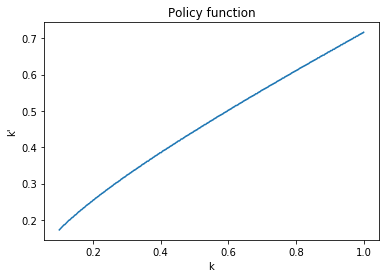

In [8]:
plt.figure()
plt.plot(k_grid, extract_policy(V))
plt.xlabel('k')
plt.ylabel("k'")
plt.title('Policy function')
plt.show();